In [16]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import sys
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy.core.multiarray

# Model-specific imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
import xgboost as xgb

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
import shap
from pathlib import Path
from sklearn_evaluation import plot

In [2]:
o = os.getcwd()
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates=True)
model_path = o + "/../models/"
plot_path = o + "/../plots/"
xgpath = model_path + 'xgbModel.pkl'
xg_pass = 'xg'

In [3]:
def categorize_column(data):
    i = 0
    for value in tqdm(data.unique()):
        data.replace(value, i, inplace=True)
        i += 1
    data = data.apply(pd.to_numeric)
    return data

In [8]:
def build_model(train, val):

    print('XGBoost Model:\n')

    print('1\tSetting training variables')
    dtrain = train.drop(columns='outcome')
    dval = val.drop(columns='outcome')
    dt_label = train['outcome']
    dv_label = val['outcome']

    print('2\tSetting custom XGB DMatrices...')
    xg_dtrain = xgb.DMatrix(dtrain, label=dt_label)
    xg_dval = xgb.DMatrix(dval, label=dv_label)
    xg_test = xgb.DMatrix(dtrain, label=dt_label)

    print('3\tSetting parameters...')
    param = {
        'objective': 'multi:softmax',
        'max_depth': 6,
        'eta': 0.05,
        'subsample': 0.25,
        'colsample_bytree': 0.25,
        'num_parallel_tree': 1,
        'min_child_weight': 2000, # originally was 1000
        'gamma': 200,
        'num_class': 4
    }
    evallist = [(xg_dval, 'eval'), (xg_dtrain, 'train')]
    num_round = 150
    early_stopping_rounds = 3

    # XGB training GO!
    print('***\tXGB Initiate\t***')
    xgb_model = xgb.train(param, xg_test, num_round, evallist,
                          early_stopping_rounds=early_stopping_rounds)
    print('***\tCOMPLETE\t***')
    return xgb_model

In [4]:
def evaluate(train, val, model, string):

    dtrain = train.drop(columns='outcome')
    dval = val.drop(columns='outcome')
    dt_label = train['outcome']
    dv_label = val['outcome']

    train_prediction = [round(value) for value in dt_label]  # from training
    prediction = [round(value) for value in dv_label]  # from validation

    print('1\tAccuracy measure:\n')
    model_predict = None
    cm_labels = train['outcome'].unique().tolist()

    if(string == xg_pass):
        print('Setting up XGBoost vars & model prediction...\n')
        xg_dtrain = xgb.DMatrix(dtrain, label=dt_label)
        xg_dval = xgb.DMatrix(dval, label=dv_label)
        model_predict = model.predict(xg_dval)
        train_accuracy = accuracy_score(
            model.predict(xg_dtrain), train_prediction)
    else:
        model_predict = model.predict(dval)
        train_accuracy = accuracy_score(
            model.predict(dtrain), dt_label)
    
    print("\tTrain Accuracy: \t%.2f%%" % (train_accuracy * 100.0))
    accuracy = accuracy_score(model_predict, prediction)
    print("\tValidation Accuracy: \t%.2f%%" % (accuracy * 100.0))
    print('\n')

    print('2\tConfusion Matrix:\n')
    cm = confusion_matrix(dv_label,model_predict, labels = cm_labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + cm_labels)
    ax.set_yticklabels([''] + cm_labels)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')

    print('3\tPrecision, Recall & F-Score:\n')
    precision = precision_score(dv_label, model_predict, average="macro")
    print('\tPrecision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(dv_label, model_predict, average="macro")
    print('\tRecall: %f' % recall)
    # f1: tp / (tp + fp + fn)
    f1 = f1_score(dv_label, model_predict, average="macro")
    print('\tF1 score: %f' % f1)
    print('\n')


In [5]:
def xg_cross_validation(train):
    print('***\tXGB CROSS VALIDATION\t***')
    xgb_class = xgb.XGBClassifier()

    print('1\tSetting up variables and parameters...')
    dtrain = train.drop(columns='outcome')
    dt_label = train['outcome']
    # commented out parameters are the ones we're testing in the CV
    params = {
        'objective': ['multi:softmax'],
        'max_depth': [6],
        'eta': [0.0001, 0.005, 0.01], # was[0.01, 0.025]
        'subsample': [0.25],
        'colsample_bytree': [0.25],
        'n_estimators': [1000],
        'min_child_weight': [1000, 2500, 5000], # was [500, 1000]
        'num_class': [4]
    }

    print('2\tSetting up cross validation with GridSearch...')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

    scoring = {
        'Overall_Accuracy': metrics.make_scorer(metrics.accuracy_score),
        'Overall_Recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
        'F1_Deceased': metrics.make_scorer(metrics.f1_score, labels=[1], average= 'micro'),
        'Recall_Deceased': metrics.make_scorer(metrics.recall_score, labels = [1], average = 'micro') 
    }

    gs = GridSearchCV(xgb_class, param_grid = params, scoring= scoring, cv=cv, n_jobs=-1, refit = 'Recall_Deceased')
    
    print('3\tStarting gs.fit()...')
    gs.fit(dtrain, dt_label)

    print('4\tGet best parameters...')
    print(gs.best_params_)
    return gs

In [6]:
print("\n\nTeam Losers: Milestone 3\n\n")
print("Modifying data for classifiers...\n")

# data = pd.read_csv( o + "\\..\\data\\cases_train_processed.csv", parse_dates=True)
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates=True)
data['sex'] = categorize_column(data['sex'])
data['outcome'] = categorize_column(data['outcome'])
data['Combined_Key'] = categorize_column(data['Combined_Key'])


# might need to drop date column if classifiers can't handle it
data = data.drop(columns=['province', 'country'])
#data = data.drop(columns=['date_confirmation'])

print("Splitting data into test and validation sets...\n")

train, val = train_test_split(
    data, test_size=0.2, random_state=69, shuffle=True)



Team Losers: Milestone 3


Modifying data for classifiers...

100%|██████████| 489/489 [00:40<00:00, 12.01it/s]
Splitting data into test and validation sets...



Building training models...

XGBoost Model:

1	Setting training variables
2	Setting custom XGB DMatrices...
3	Setting parameters...
***	XGB Initiate	***
[12:46:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:1.34035	train-mlogloss:1.34015
[1]	eval-mlogloss:1.29178	train-mlogloss:1.29151
[2]	eval-mlogloss:1.25393	train-mlogloss:1.25388
[3]	eval-mlogloss:1.21674	train-mlogloss:1.21629
[4]	eval-mlogloss:1.18285	train-mlogloss:1.18257
[5]	eval-mlogloss:1.15168	train-mlogloss:1.15120
[6]	eval-mlogloss:1.12266	train-mlogloss:1.12213
[7]	eval-mlogloss:1.09082	train-mlogloss:1.09020
[8]	eval-mlogloss:1.06150	train-mlogloss:1.06087
[9]	eval-mlogloss:1.03752	train-mlogloss:1.03689
[10]	eval-mlogloss:1.01323	train-mlogloss:1.01262
[11]	eval-mlogloss:0.9923

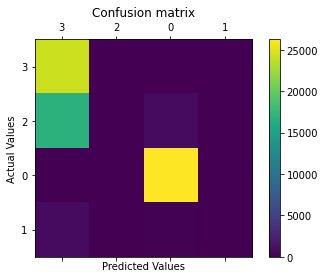

In [9]:
print("Building training models...\n")
xg_model = build_model(train, val)

print("Model building completed, Evaluating models...\n")
evaluate(train, val, xg_model, xg_pass)

In [10]:
print("Cross Validation testing\n")
gs = xg_cross_validation(data)

Cross Validation testing

***	XGB CROSS VALIDATION	***
1	Setting up variables and parameters...
2	Setting up cross validation with GridSearch...
3	Starting gs.fit()...
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[13:45:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4	Get best parameters...
{'colsample_bytree': 0.25, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 500, 'n_estimators': 1000, 'num_class': 4, 'objective': 'multi:softmax', 'subsample': 0.25}


In [12]:
def create_model_file(gs, filename):
    lines = str(gs.cv_results_)
    line_list = lines.split(',')
    with open(filename, 'w') as f:
        f.writelines(',\n'.join(line_list))

In [13]:
xgb_file = plot_path + "xgb_file.txt"
create_model_file(gs, xgb_file)

In [42]:
def plot_overall_accuracy(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Overall_Accuracy']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Overall_Accuracy']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Overall Accuracy Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

In [43]:
def plot_overall_recall(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Overall_Recall']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Overall_Recall']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Overall Recall Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

In [44]:
def plot_F1_deceased(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_F1_Deceased']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_F1_Deceased']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("F1 Deceased Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

In [45]:
def plot_recall_deceased(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Recall_Deceased']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Recall_Deceased']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Recall Deceased Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

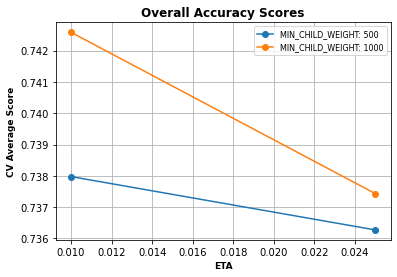

In [46]:
eta = [0.0001, 0.005, 0.01] # was[0.01, 0.025]
min_child_weight = [1000, 2500, 5000] # was [500, 1000]
plot_overall_accuracy(gs.cv_results_, eta, min_child_weight, 'ETA', 'MIN_CHILD_WEIGHT')

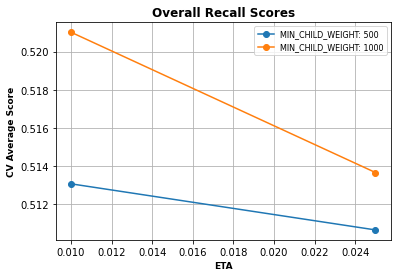

In [48]:
plot_overall_recall(gs.cv_results_, eta, min_child_weight, 'ETA', 'MIN_CHILD_WEIGHT')

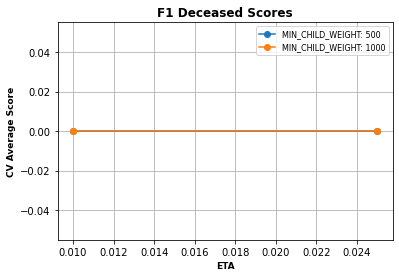

In [49]:
plot_F1_deceased(gs.cv_results_, eta, min_child_weight, 'ETA', 'MIN_CHILD_WEIGHT')

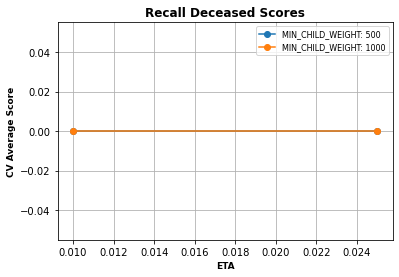

In [50]:
plot_recall_deceased(gs.cv_results_, eta, min_child_weight, 'ETA', 'MIN_CHILD_WEIGHT')